# Autoencoders

Author: https://www.github.com/deburky

Autoencoders turn a supervised learning problem into an unsupervised one. The idea is to train a model to predict its own input.

The model will learn to create some latent representation of the input data, which it can later use to decode back to the original input. The core idea is to make the model learn some interesting features of the data.

The function of the model: $f(x, \theta) \approx x$

Where $x$ is the input and $\theta$ are the parameters of the neural network.

## Dataset

This dataset is a subset of Food-101. It contains 150 training images and 50 validation images for 10 easily classified foods: 
* apple pie
* bibimbap
* cannoli
* edamame
* falafel
* french toast
* ice cream
* ramen
* sushi
* tiramisu

We will use 10% of the data for CPU training.

Source: [food-101-tiny](https://www.kaggle.com/datasets/msarmi9/food101tiny/data)

In [1]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Path to your image folder
data_path = './data/food-101-tiny/train'

# Load the dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

In [2]:
from torch.utils.data import Subset
import numpy as np

# Define the subset size
subset_size = int(0.2 * len(dataset))
indices = np.random.choice(len(dataset), subset_size, replace=False)
subset = Subset(dataset, indices)

# Create a DataLoader for the subset
data_loader = DataLoader(subset, batch_size=32, shuffle=True)

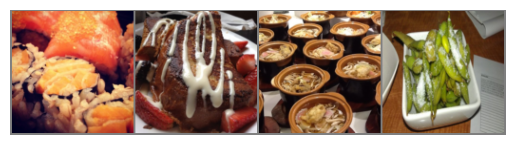

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of images
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

## Autoencoder

An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction.

Autoencoders are primarily focused with reconstructing the input data, but not generating new data samples.

However, the autoencoder can also be used to generate new data samples.

* [Loss function for autoencoders](https://stats.stackexchange.com/questions/245448/loss-function-for-autoencoders)


In [4]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: Compresses the input
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 128 * 128, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.SiLU()
        )
        # Decoder: Reconstructs the input
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 128 * 128),
            nn.Tanh(),
            nn.Unflatten(1, (3, 128, 128)) 
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def combined_loss(reconstructed, original):
    mse_loss = nn.MSELoss()(reconstructed, original)
    mae_loss = nn.L1Loss()(reconstructed, original)
    return mse_loss + 1.0 * mae_loss

In [5]:
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(0)

# Instantiate the model
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in data_loader:
        
        # Forward pass
        outputs = model(images)
        loss = combined_loss(outputs, images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(data_loader):.4f}")

Epoch 1/100, Loss: 0.7344
Epoch 2/100, Loss: 0.5795
Epoch 3/100, Loss: 0.5427
Epoch 4/100, Loss: 0.5219
Epoch 5/100, Loss: 0.4993
Epoch 6/100, Loss: 0.4774
Epoch 7/100, Loss: 0.4490
Epoch 8/100, Loss: 0.4316
Epoch 9/100, Loss: 0.4239
Epoch 10/100, Loss: 0.4123
Epoch 11/100, Loss: 0.3939
Epoch 12/100, Loss: 0.3835
Epoch 13/100, Loss: 0.3730
Epoch 14/100, Loss: 0.3678
Epoch 15/100, Loss: 0.3575
Epoch 16/100, Loss: 0.3470
Epoch 17/100, Loss: 0.3397
Epoch 18/100, Loss: 0.3276
Epoch 19/100, Loss: 0.3225
Epoch 20/100, Loss: 0.3197
Epoch 21/100, Loss: 0.3115
Epoch 22/100, Loss: 0.3055
Epoch 23/100, Loss: 0.3023
Epoch 24/100, Loss: 0.2918
Epoch 25/100, Loss: 0.2817
Epoch 26/100, Loss: 0.2784
Epoch 27/100, Loss: 0.2746
Epoch 28/100, Loss: 0.2670
Epoch 29/100, Loss: 0.2595
Epoch 30/100, Loss: 0.2572
Epoch 31/100, Loss: 0.2568
Epoch 32/100, Loss: 0.2571
Epoch 33/100, Loss: 0.2525
Epoch 34/100, Loss: 0.2427
Epoch 35/100, Loss: 0.2418
Epoch 36/100, Loss: 0.2322
Epoch 37/100, Loss: 0.2275
Epoch 38/1

Original Images


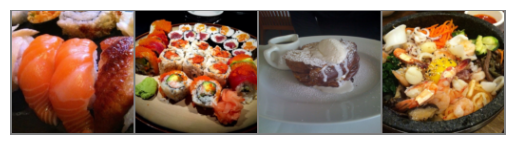

Reconstructed Images


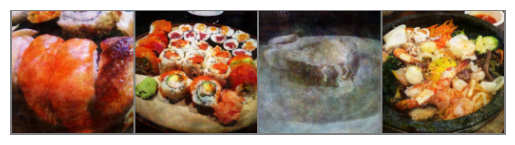

In [6]:
import torch

# Switch to evaluation mode
model.eval()

# Get a batch of test images
data_iter = iter(data_loader)
images, _ = next(data_iter)

# Reconstruct the images
with torch.no_grad():
    reconstructed = model(images)

# Display original images
print("Original Images")
imshow(torchvision.utils.make_grid(images[:4]))

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed[:4]))

Original Images


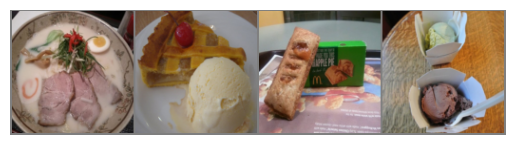

Noisy Images


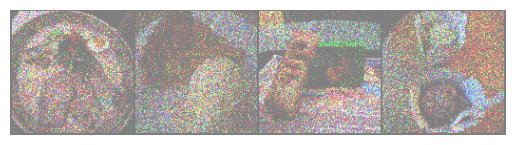

Reconstructed Images (Denoised)


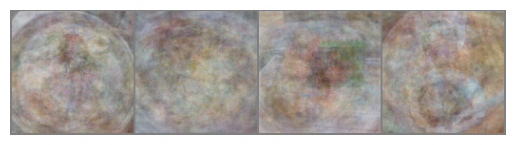

In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def add_noise(images, noise_factor=0.5):
    """
    Adds random Gaussian noise to the images.
    :param images: Original images (Tensor).
    :param noise_factor: The intensity of the noise.
    :return: Noisy images (Tensor).
    """
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    # Clamp to ensure values are between 0 and 1
    return torch.clamp(noisy_images, 0., 1.)

# Switch the model to evaluation mode
model.eval()

# Get a batch of test images
data_iter = iter(data_loader)
images, _ = next(data_iter)

# Add noise to the images
noisy_images = add_noise(images)

with torch.no_grad():
    reconstructed = model(noisy_images)

# Function to display images
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Display the original, noisy, and reconstructed images side by side
print("Original Images")
imshow(torchvision.utils.make_grid(images[:4]))

print("Noisy Images")
imshow(torchvision.utils.make_grid(noisy_images[:4]))

print("Reconstructed Images (Denoised)")
imshow(torchvision.utils.make_grid(reconstructed[:4]))

## Convolutional Autoencoder

Convolutional autoencoders (CAE) are a specific type of autoencoder that use convolutional layers instead of dense layers.

* Designed specifically for image data, leveraging convolutional layers to better capture spatial hierarchies and local patterns in the data.
* Uses convolutional layers in the encoder and transposed convolutional layers in the decoder.
* Captures more complex spatial structures and details, making it effective for tasks like image denoising, super-resolution, and feature extraction

In [8]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(0)

# Instantiate the model
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in data_loader:
        
        # Forward pass
        outputs = model(images)
        loss = combined_loss(outputs, images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(data_loader):.4f}")

Epoch 1/100, Loss: 0.5995
Epoch 2/100, Loss: 0.2969
Epoch 3/100, Loss: 0.2309
Epoch 4/100, Loss: 0.2022
Epoch 5/100, Loss: 0.1808
Epoch 6/100, Loss: 0.1626
Epoch 7/100, Loss: 0.1574
Epoch 8/100, Loss: 0.1519
Epoch 9/100, Loss: 0.1420
Epoch 10/100, Loss: 0.1364
Epoch 11/100, Loss: 0.1357
Epoch 12/100, Loss: 0.1236
Epoch 13/100, Loss: 0.1297
Epoch 14/100, Loss: 0.1252
Epoch 15/100, Loss: 0.1189
Epoch 16/100, Loss: 0.1170
Epoch 17/100, Loss: 0.1085
Epoch 18/100, Loss: 0.1150
Epoch 19/100, Loss: 0.1063
Epoch 20/100, Loss: 0.1103
Epoch 21/100, Loss: 0.1058
Epoch 22/100, Loss: 0.1000
Epoch 23/100, Loss: 0.0993
Epoch 24/100, Loss: 0.0955
Epoch 25/100, Loss: 0.0990
Epoch 26/100, Loss: 0.0945
Epoch 27/100, Loss: 0.1016
Epoch 28/100, Loss: 0.0986
Epoch 29/100, Loss: 0.1057
Epoch 30/100, Loss: 0.0960
Epoch 31/100, Loss: 0.0994
Epoch 32/100, Loss: 0.1096
Epoch 33/100, Loss: 0.0916
Epoch 34/100, Loss: 0.0912
Epoch 35/100, Loss: 0.0881
Epoch 36/100, Loss: 0.0862
Epoch 37/100, Loss: 0.0882
Epoch 38/1

Original Images


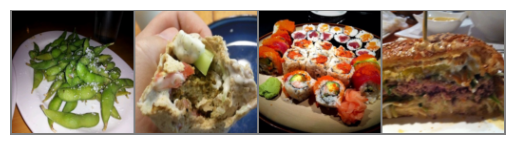

Reconstructed Images


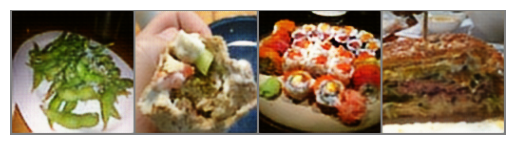

In [10]:
import torch

# Switch to evaluation mode
model.eval()

# Get a batch of test images
data_iter = iter(data_loader)
images, _ = next(data_iter)

# Reconstruct the images
with torch.no_grad():
    reconstructed = model(images)

# Display original images
print("Original Images")
imshow(torchvision.utils.make_grid(images[:4]))

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed[:4]))

Original Images


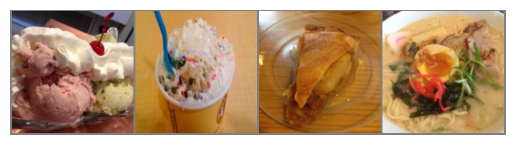

Noisy Images


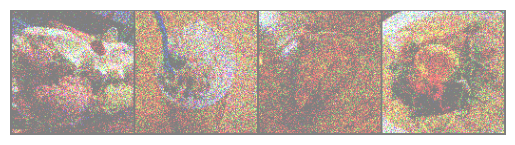

Reconstructed Images (Denoised)


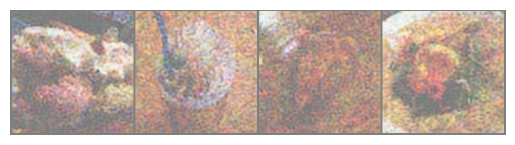

In [11]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def add_noise(images, noise_factor=0.5):
    """
    Adds random Gaussian noise to the images.
    :param images: Original images (Tensor).
    :param noise_factor: The intensity of the noise.
    :return: Noisy images (Tensor).
    """
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    # Clamp to ensure values are between 0 and 1
    return torch.clamp(noisy_images, 0., 1.)

# Switch the model to evaluation mode
model.eval()

# Get a batch of test images
data_iter = iter(data_loader)
images, _ = next(data_iter)

# Add noise to the images
noisy_images = add_noise(images)

with torch.no_grad():
    reconstructed = model(noisy_images)

# Function to display images
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Display the original, noisy, and reconstructed images
print("Original Images")
imshow(torchvision.utils.make_grid(images[:4]))

print("Noisy Images")
imshow(torchvision.utils.make_grid(noisy_images[:4]))

print("Reconstructed Images (Denoised)")
imshow(torchvision.utils.make_grid(reconstructed[:4]))

## Variational Autoencoder

Variational autoencoders (VAE) are a type of autoencoder with added constraints on the encoded representations being learned. More precisely, they are generative models that learn the underlying structure of the data.

* Enables generative modeling by learning a structured latent space, making it possible to sample new images.
* Includes additional layers to predict the mean and variance for each latent dimension. This allows sampling from a Gaussian distribution.
* Generates new, diverse images by sampling from the learned latent space. The structured latent space also allows smooth interpolation between data points.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim=3*128*128, hidden_dim=1024, latent_dim=128):
        super(VariationalAutoencoder, self).__init__()
        self.input_dim = input_dim

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        x = x.view(-1, self.input_dim)  # Flatten the input
        h = F.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        x_recon = torch.tanh(self.fc4(h))
        return x_recon.view(-1, 3, 128, 128)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def recon_kl_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (BCE for pixel-wise similarity)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss

In [13]:
import torch.optim as optim

# Instantiate the model
model = VariationalAutoencoder(input_dim=3*128*128, hidden_dim=1024, latent_dim=512)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in data_loader:
        
        # Forward pass through the model
        recon_images, mu, logvar = model(images)
        
        # Compute the VAE loss
        loss = recon_kl_loss(recon_images, images, mu, logvar)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(data_loader):.4f}")

Epoch 1/200, Loss: 525172.3875
Epoch 2/200, Loss: 465873.1391
Epoch 3/200, Loss: 413471.5469
Epoch 4/200, Loss: 382911.1312
Epoch 5/200, Loss: 358537.3125
Epoch 6/200, Loss: 337360.6070
Epoch 7/200, Loss: 319524.5508
Epoch 8/200, Loss: 305222.5578
Epoch 9/200, Loss: 293512.6102
Epoch 10/200, Loss: 284258.3234
Epoch 11/200, Loss: 275422.7734
Epoch 12/200, Loss: 266312.7664
Epoch 13/200, Loss: 256777.4328
Epoch 14/200, Loss: 248318.4281
Epoch 15/200, Loss: 240468.0273
Epoch 16/200, Loss: 233377.1820
Epoch 17/200, Loss: 227491.2156
Epoch 18/200, Loss: 222382.5781
Epoch 19/200, Loss: 216880.1812
Epoch 20/200, Loss: 211041.2719
Epoch 21/200, Loss: 205935.3758
Epoch 22/200, Loss: 201060.6063
Epoch 23/200, Loss: 196898.2195
Epoch 24/200, Loss: 193270.2328
Epoch 25/200, Loss: 189040.7773
Epoch 26/200, Loss: 184696.3711
Epoch 27/200, Loss: 180862.2086
Epoch 28/200, Loss: 177787.5055
Epoch 29/200, Loss: 174781.7141
Epoch 30/200, Loss: 171703.0527
Epoch 31/200, Loss: 167937.4859
Epoch 32/200, Los

Original Images


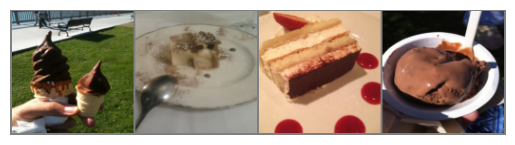

Reconstructed Images


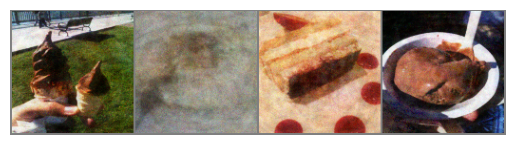

In [14]:
import torch

# Switch to evaluation mode
model.eval()

# Get a batch of test images
data_iter = iter(data_loader)
images, _ = next(data_iter)

# Reconstruct the images
with torch.no_grad():
    reconstructed, mu, var = model(images)

# Display original images
print("Original Images")
imshow(torchvision.utils.make_grid(images[:4]))

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed[:4]))

Original Images


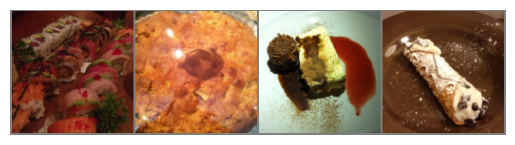

Noisy Images


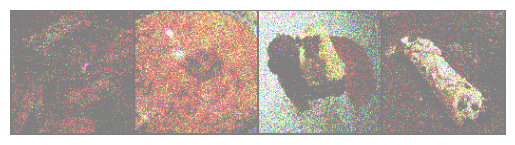

Reconstructed Images (Denoised)


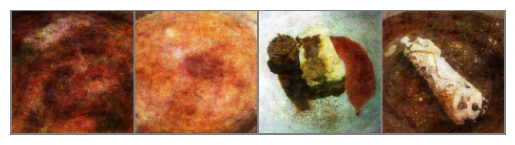

In [15]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def add_noise(images, noise_factor=0.5):
    """
    Adds random Gaussian noise to the images.
    :param images: Original images (Tensor).
    :param noise_factor: The intensity of the noise.
    :return: Noisy images (Tensor).
    """
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    # Clamp to ensure values are between 0 and 1
    return torch.clamp(noisy_images, 0., 1.)

# Switch the model to evaluation mode
model.eval()

# Get a batch of test images
data_iter = iter(data_loader)
images, _ = next(data_iter)

# Add noise to the images
noisy_images = add_noise(images)

with torch.no_grad():
    reconstructed, mu, var = model(images)

# Function to display images
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Display the original, noisy, and reconstructed images
print("Original Images")
imshow(torchvision.utils.make_grid(images[:4]))

print("Noisy Images")
imshow(torchvision.utils.make_grid(noisy_images[:4]))

print("Reconstructed Images (Denoised)")
imshow(torchvision.utils.make_grid(reconstructed[:4]))